<a href="https://colab.research.google.com/github/sujitojha1/EVA4/blob/rev7/S14_15/EVA4_S15a_Solution_DenseDepth_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EVA4 Session 14 & 15 Assignment - DepthMap Creation

## 1. Loading the DenseDepth git & configure the setup

In [1]:
#Cloning the libraries
!git clone -q https://github.com/ialhashim/DenseDepth.git

#Downloading the model weight files
!wget -q https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5 -O ./DenseDepth/nyu.h5

# Forcing the given library
!pip install tensorflow-gpu==1.13.1 --quiet
!pip install q keras==2.2.4 --quiet

     |████████████████████████████████| 345.2MB 29kB/s 
     |████████████████████████████████| 368kB 46.7MB/s 
     |████████████████████████████████| 3.2MB 54.1MB/s 
ERROR: tensorflow 2.2.0rc4 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 1.13.1 which is incompatible.
ERROR: tensorflow 2.2.0rc4 has requirement tensorflow-estimator<2.3.0,>=2.2.0, but you'll have tensorflow-estimator 1.13.0 which is incompatible.
     |████████████████████████████████| 317kB 4.1MB/s 


In [2]:
cd DenseDepth/

/content/DenseDepth


In [0]:
import os

#from DenseDepth import utils    #### load_execute_names
# Keras / TensorFlow
from keras.models import load_model
from layers import BilinearUpSampling2D
from utils import predict, load_images, display_images, to_multichannel

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'

In [38]:
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}
print('Loading model...')
# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)
#utils.load_execute_names(model, input_zip, file_list)

Loading model...


## 2. Loading the foreground and background images

In [0]:
!wget -q https://github.com/sujitojha1/EVA4/releases/download/yolo/images.zip
!unzip -q -o images.zip
!rm images.zip

## 3. Generate fg_bg & fg_mask dataset 

In [0]:
import glob
from PIL import Image
from PIL import ImageOps

# Getting file list
fg_file_list = [filepath for filepath in sorted(glob.iglob('images/fr_grnd/fg*.png'))]
bg_file_list = [filepath for filepath in sorted(glob.iglob('images/bk_grnd/bg*.jpg'))]

In [0]:
!rm -rf fg_bg.zip
!rm -rf mask.zip
!rm -rf depth_map.zip

!rm -rf fg_bg
!rm -rf mask
!rm -rf depth_map

!mkdir fg_bg
!mkdir mask
!mkdir depth_map

In [0]:
run_id = 0

In [189]:
import numpy as np
from zipfile import ZipFile

print("Run id : "+ str(run_id))
fg_filename = fg_file_list[run_id]
#bg_filename = bg_file_list[0]

fg_bg_zip = ZipFile('fg_bg.zip', mode='a', compression=zipfile.ZIP_STORED)
mask_zip = ZipFile('mask.zip', mode='a', compression=zipfile.ZIP_STORED)
depth_map_zip = ZipFile('depth_map.zip', mode='a', compression=zipfile.ZIP_STORED)


#for fg_filename in fg_file_list:
for bg_filename in bg_file_list:

  # 

  fg_bg_filelist = []
  mask_filelist = []

  # Open foreground & foreground mask file
  im_fg = Image.open(fg_filename)
  im_fg_mask = Image.open(fg_filename.replace("fr_grnd/fg","fr_grnd_msk/fg_mask"))

  # Open background file & create background mask file
  im_bg = Image.open(bg_filename)
  im_bg_mask = Image.new("RGBA", im_bg.size, 0)

  # Resizing and creating a flip & maks copy
  dim = (65, 65)
  im_fg = im_fg.resize(dim,Image.LANCZOS)
  im_fg_flip = ImageOps.mirror(im_fg)
  im_fg_mask = im_fg_mask.resize(dim,Image.LANCZOS)
  im_fg_mask_flip = ImageOps.mirror(im_fg_mask)

  # Generating random x & y locations for pasting foreground object
  index=0
  x_choices = np.random.choice(165, 20, replace=False)
  y_choices = np.random.choice(165, 20, replace=False)

  dim_bg = (224,224)

  # Generating with original foreground
  for x,y in zip(x_choices,y_choices):
      
      back_im = im_bg.copy().resize(dim_bg,Image.LANCZOS)
      back_im.paste(im_fg, (x, y),im_fg)

      filename = bg_filename.split("/")[-1].split('.')[0] + "_" + fg_filename.split("/")[-1].split('.')[0] + "_idx_" + str(index) + ".jpg"
      back_im.save("./fg_bg/" + filename)
      fg_bg_filelist.append("./fg_bg/" + filename)
      fg_bg_zip.write("fg_bg/" + filename)
      
      filename = bg_filename.split("/")[-1].split('.')[0] + "_" + fg_filename.split("/")[-1].split('.')[0] + "_idx_" + str(index) + ".png"
      back_im = im_bg_mask.copy().resize(dim_bg,Image.LANCZOS)
      back_im.paste(im_fg_mask, (x, y),im_fg_mask)
      back_im.save("./mask/" + filename)
      mask_zip.write("mask/" + filename)
      #mask_filelist.append("./mask/" + filename)

      index+=1

  # Generating with flipped foreground   
  x_choices = np.random.choice(165, 20, replace=False)
  y_choices = np.random.choice(165, 20, replace=False)

  for x,y in zip(x_choices,y_choices):

      back_im = im_bg.copy().resize(dim_bg,Image.LANCZOS)
      back_im.paste(im_fg_flip, (x, y),im_fg_flip)

      filename = bg_filename.split("/")[-1].split('.')[0] + "_" + fg_filename.split("/")[-1].split('.')[0] + "_idx_" + str(index) + ".jpg"
      back_im.save("./fg_bg/" + filename)
      fg_bg_filelist.append("./fg_bg/" + filename)
      fg_bg_zip.write("fg_bg/" + filename)
      
      filename = bg_filename.split("/")[-1].split('.')[0] + "_" + fg_filename.split("/")[-1].split('.')[0] + "_idx_" + str(index) + ".png"
      back_im = im_bg_mask.copy().resize(dim_bg,Image.LANCZOS)
      back_im.paste(im_fg_mask_flip, (x, y),im_fg_mask_flip)
      back_im.save("./mask/" + filename)
      mask_zip.write("mask/" + filename)
      #mask_filelist.append("./mask/" + filename)

      index+=1

  # Creating depth map
  #image_list = [Image.open(name) for name in fg_bg_filelist]   
  inputs = load_images(fg_bg_filelist)
  #print('Loaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
  outputs = predict(model, inputs)

  for i in range(outputs.shape[0]):
    depthmap_filename = "depth_map/" +fg_bg_filelist[i].split("/")[-1]
    Image.fromarray(np.uint8(to_multichannel(outputs[i])*255)).save(depthmap_filename, 'JPEG',quality=100)
    depth_map_zip.write(depthmap_filename)

fg_bg_zip.close()
mask_zip.close()
depth_map_zip.close()

!rm fg_bg/*
!rm mask/*
!rm depth_map/*
run_id+=1

Run id : 99


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r fg_bg.zip '/content/drive/My Drive/EVA4/S15/'
!cp -r mask.zip '/content/drive/My Drive/EVA4/S15/'
!cp -r depth_map.zip '/content/drive/My Drive/EVA4/S15/'

## 4. Plotting Depth Map (sample)

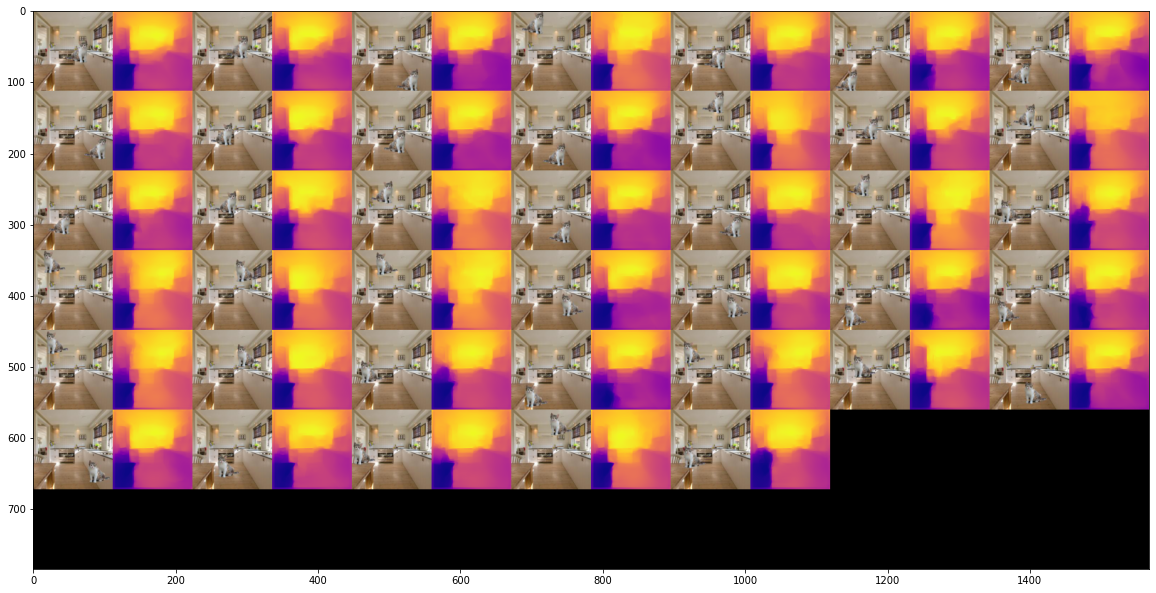

In [194]:
from matplotlib import pyplot as plt
from skimage import io

viz = display_images(outputs.copy(), inputs.copy())
plt.figure(figsize=(20,20))
plt.imshow(viz)
plt.savefig('test.png')

# plt.figure(figsize=(20,20))
# plt.imshow(io.imread('test.png') )

## 5. Plotting foreground

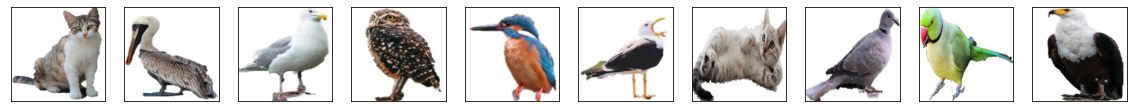

In [264]:
import skimage
from skimage.transform import resize

file_choices = list(np.random.choice(100, 10, replace=False))
fg_file_list = [filepath for filepath in sorted(glob.iglob('images/fr_grnd/fg*.png'))]
fg_shortlist = [fg_file_list[idx] for idx in file_choices]

fig = plt.figure(figsize=(20, 20))
for i in range(1, 11):
  npimg = np.clip(np.asarray(Image.open(fg_shortlist[i-1]).resize((224,224),Image.LANCZOS), dtype=float) / 255, 0, 1)
  ax = fig.add_subplot(1, 10, i,xticks=[],yticks=[])
  ax.imshow(npimg, cmap='gray')
#plt.axis('off')

## 6. Plotting Background

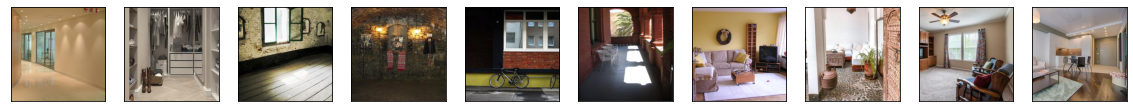

In [265]:
file_choices = list(np.random.choice(100, 10, replace=False))
bg_file_list = [filepath for filepath in sorted(glob.iglob('images/bk_grnd/bg*.jpg'))]
bg_shortlist = [bg_file_list[idx] for idx in file_choices]

fig = plt.figure(figsize=(20, 20))
for i in range(1, 11):
  npimg = np.clip(np.asarray(Image.open(bg_shortlist[i-1]).resize((224,224),Image.LANCZOS), dtype=float) / 255, 0, 1)
  ax = fig.add_subplot(1, 10, i,xticks=[],yticks=[])
  ax.imshow(npimg, cmap='gray')
#plt.axis('off')

## 7. Plotting foreground + background images

In [0]:
!cp -r '/content/drive/My Drive/EVA4/S15/fg_bg.zip' fg_bg.zip 
!cp -r '/content/drive/My Drive/EVA4/S15/mask.zip' mask.zip 
!cp -r '/content/drive/My Drive/EVA4/S15/depth_map.zip' depth_map.zip 

In [0]:
from zipfile import ZipFile
fg_bg_zip = ZipFile("fg_bg.zip")
mask_zip = ZipFile("mask.zip")
depth_map_zip = ZipFile("depth_map.zip")

fg_bg_list = [name for name in fg_bg_zip.namelist()]
mask_list = [name for name in mask_zip.namelist()]
depth_map_list = [name for name in depth_map_zip.namelist()]

In [0]:
from io import BytesIO

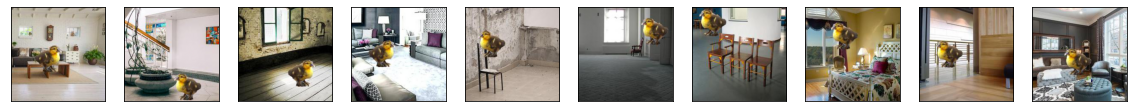

In [19]:
file_choices = list(np.random.choice(4000, 10, replace=False))
fg_bg_shortlist = [fg_bg_list[idx] for idx in file_choices]

fig = plt.figure(figsize=(20, 20))
for i in range(1, 11):
  npimg = np.clip(np.asarray(Image.open(BytesIO(fg_bg_zip.read(fg_bg_shortlist[i-1]))).resize((224,224),Image.LANCZOS), dtype=float)/ 255, 0, 1)
  ax = fig.add_subplot(1, 10, i,xticks=[],yticks=[])
  ax.imshow(npimg, cmap='gray')

## 8. Plotting foreground + background mask

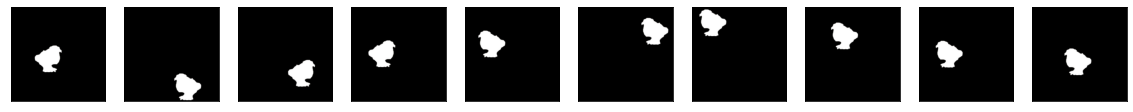

In [22]:
fg_bg_mask_shortlist = [filename.replace("fg_bg","mask").replace("jpg",'png') for filename in fg_bg_shortlist]

fig = plt.figure(figsize=(20, 20))
for i in range(1, 11):
  npimg = np.clip(np.asarray(Image.open(BytesIO(mask_zip.read(fg_bg_mask_shortlist[i-1]))).convert("RGB").resize((224,224),Image.LANCZOS), dtype=float)/ 255, 0, 1)
  ax = fig.add_subplot(1, 10, i,xticks=[],yticks=[])
  ax.imshow(npimg, cmap='gray')

## 9. Plotting Depth Map

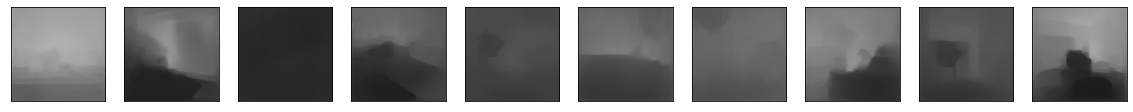

In [25]:
depth_map_shortlist = [filename.replace("fg_bg","depth_map") for filename in fg_bg_shortlist]

#depth_map_img_files = load_images(depth_map_shortlist)

plasma = plt.get_cmap('plasma')

fig = plt.figure(figsize=(20, 20))
for i in range(1, 11):
  npimg = np.clip(np.asarray(Image.open(BytesIO(depth_map_zip.read(depth_map_shortlist[i-1]))).resize((224,224),Image.LANCZOS), dtype=float)/ 255, 0, 1)
  ax = fig.add_subplot(1, 10, i,xticks=[],yticks=[])
  ax.imshow(npimg, cmap='plasma')

## 10. Data Summary

In [0]:
# Foreground & Background image, Mean and standard deviation
fg_bg_image_list = [np.asarray(Image.open(BytesIO((fg_bg_zip.read(name)))),dtype=float) for name in fg_bg_list ] 